In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import multiprocessing as mp
import scipy.stats as stats
from scipy.interpolate import UnivariateSpline

In [4]:
with pd.get_store('/home/matt/Dropbox/data/fss/data.h5') as store:
    data = store.select('old/periodic', columns=['M2','M4'])
    
data.index.names = [s if s != 'Stage' else 'LogSweeps' for s in data.index.names]

In [ ]:
data.head()

In [ ]:
def binderG(df):
    n = len(df)
    xj = (df.sum() - df) / (n - 1.)
    gj = xj.eval('0.5*(3. - M4/M2**2)')
    return pd.Series({'mean': gj.mean(), 'sem': sqrt(n) * gj.std()})

In [6]:
G = data.groupby(level=['L','Temp','k','LogSweeps']).apply(binderG)

In [7]:
#G.to_hdf('binderG-periodic.h5','data')

In [5]:
G = pd.read_hdf('binderG-periodic.h5','data')

In [6]:
G.head()

mean       sem
L Temp     k LogSweeps                    
8 8.668015 0 4          0.952813  0.001514
             5          0.949005  0.001226
             6          0.947281  0.000899
             7          0.948004  0.000661
             8          0.946243  0.000472

# $k=0$

In [9]:
Gk0 = G.xs(0,level='k')

In [ ]:
for L, df in Gk0.groupby(level='L'):
    df.reset_index(inplace=True)
    df = df[(df.Temp >= 8.75) & (df.Temp <= 8.81)]
    df = df[df.LogSweeps == df.LogSweeps.max()]
    errorbar(df.Temp, df['mean'], df['sem'])
    
    df.to_csv('../data/binder-p-L{:02d}.csv'.format(L), index=False)

In [ ]:
Gk0.head()

In [11]:
def interpolate(y, T=8.77846):
    
    Temp = y.index.get_level_values('Temp')
    
    try:
        f = UnivariateSpline(Temp, y['mean'], w=1/y['sem'])
        return f(T).item()
    except:
        return nan

In [ ]:
Gk0.groupby(level=['L','LogSweeps']).apply(interpolate).head()

In [14]:
datak0 = data.xs(0, level='k')

In [15]:
datak0.head()

M2        M4
L Temp     LogSweeps Run                    
8 8.668015 4         0    0.053850  0.003073
                     1    0.045166  0.002139
                     2    0.055251  0.003502
                     3    0.053550  0.003027
                     4    0.057807  0.003711

In [16]:
def compute_g_Tc(data):
    groupby = ['L','Temp','LogSweeps']    
    G = data.groupby(level=groupby, group_keys=False).apply(binderG)
    return G.groupby(level=['L','LogSweeps']).apply(interpolate)

In [25]:
compute_g_Tc(datak0).head()

L  LogSweeps
8  4            0.480537
   5            0.475443
   6            0.471205
   7            0.471102
   8            0.468442
dtype: float64

In [28]:
def bootstrap_sample(groups):
    return groups.apply(lambda x: x.take(random_integers(0, len(x)-1, len(x))))

class BootstrapSampler:
    
    def __init__(self, data, groupby, reducer):
        self.data = data
        self.groupby = groupby
        self.reducer = reducer
        
    def __call__(self, seed):
        random.seed(seed)
        resamp = bootstrap_sample(self.data.groupby(level=self.groupby, group_keys=False))
        return self.reducer(resamp)

In [31]:
seeds = random_integers(1e5, size=100)
bs = BootstrapSampler(datak0, ['L','Temp','LogSweeps'], compute_g_Tc)

with mp.Pool(4) as p:
    samples = p.map(bs, seeds)

samples = pd.concat(samples, keys=seeds, names=['seed'])

In [32]:
#samples.to_hdf('gx-samples.h5', 'samples')

In [33]:
samples = pd.read_hdf('gx-samples.h5', 'samples')

In [34]:
gx = samples.groupby(level=['L','LogSweeps']).agg(['mean','std'])

In [35]:
gx.head()

mean       std
L LogSweeps                    
8 4          0.485960  0.007792
  5          0.471480  0.010102
  6          0.470267  0.002965
  7          0.469745  0.002177
  8          0.465732  0.001730

(0.4, 0.48)

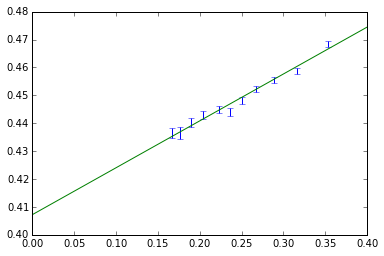

In [48]:
logt = gx.index.get_level_values('LogSweeps')
df = gx[logt == logt.max()]
df = df.reset_index()[['L','mean','std']]
errorbar(df['L']**-0.5, df['mean'], df['std'], ls='')

# save data
df.to_csv('../../data/gx-p.csv', index=False)

# fit
x = df['L']**-0.5
p, cov = polyfit(x, df['mean'], 1, w=1/df['std'], cov=True)
perr = sqrt(diag(cov))
chi2 = sum(((polyval(p, x) - df['mean'])/df['std'])**2)
ndf = len(x) - len(p)
Q = 1 - stats.chi2.cdf(chi2, ndf)

x = [0, xlim()[1]]
plot(x, polyval(p, x))

# save fit params
params = pd.DataFrame(
    [p[0], perr[0], p[1], perr[1]], 
    index=['slope','slope_err','gx','gx_err']).T
params.to_csv('../../fits/gx.fit.csv', index=False)

xlim(0,0.4)
ylim(0.4,0.48)

In [49]:
params

,slope,slope_err,gx,gx_err
0,0.168074,0.009,0.40722,0.00242


In [50]:
p

array([ 0.16807401,  0.40721981])

In [43]:
Q

0.22436309331647841

# $k\neq 0$

In [9]:
chi = data.eval('L**5 * M2').groupby(level=['L','Temp','k','LogSweeps']).agg(['mean','sem'])

In [10]:
chi.head()

mean        sem
L Temp     k LogSweeps                        
8 8.668015 0 4          1866.599456  12.040163
             5          1841.101791   8.863888
             6          1823.318662   6.003573
             7          1826.540994   4.409372
             8          1816.579015   3.134778

Read in old data with big temperature range

In [11]:
from glob import glob

opts = dict(delim_whitespace=True, comment='#',
            names=['bc','d','L','Temp','k','chi','chi_err','nrun'],
            index_col=['L','Temp','k'])

wide = pd.concat([pd.read_csv(f, **opts) for f in glob('modes-wide/*.txt')])
chi_wide = wide[['chi','chi_err']]
chi_wide.columns = ['mean','sem']

In [12]:
chi_wide.head()

mean       sem
L  Temp k                         
28 8.34 10000   8.557061  0.024949
        11000   8.106414  0.019263
   8.37 10000   9.328395  0.023970
        11000   8.711473  0.024004
   8.40 10000  10.161195  0.024569

Get data for longest time from new data, combine with old

In [13]:
chi_final = chi.groupby(level=['L','Temp','k']).apply(
    lambda x: x.iloc[argmax(x.index.get_level_values('LogSweeps'))])

chi_final_all = pd.concat((chi_final, chi_wide)).sortlevel()

In [14]:
chi_final_all.head()

mean       sem
L Temp k                        
8 7.9  10000  2.730904  0.006064
       10000  2.730904  0.006064
       11000  2.217209  0.005233
       11100  1.876677  0.003402
       11110  1.625085  0.002926

(5, 400)

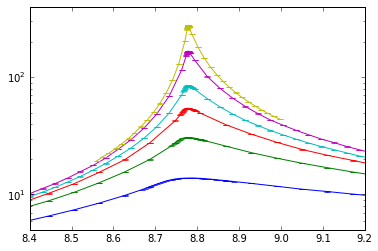

In [15]:
for L, df in chi_final_all.xs(10000,level='k').groupby(level='L'):
    
    if L not in chi_wide.index.get_level_values('L'):
        # skip sizes that don't have wide-range data
        continue
        
    df.reset_index(inplace=True)
    errorbar(df.Temp, df['mean'], df['sem'], label='{}'.format(L))
    
    # save data
    df.to_csv('../data/chi-p-k10-wide-L{:02d}.csv'.format(L), index=False)
    
yscale('log')
xlim(8.4, 9.2)
ylim(5, 400)

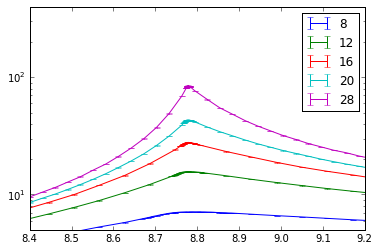

In [16]:
for L, df in chi_final_all.xs(11000,level='k').groupby(level='L'):
    
    if L not in chi_wide.index.get_level_values('L') or L==36:
        # skip sizes that don't have wide-range data
        continue
        
    df.reset_index(inplace=True)
    errorbar(df.Temp, df['mean'], df['sem'], label='{}'.format(L))
    
    # save data
    df.to_csv('../data/chi-p-k110-wide-L{:02d}.csv'.format(L), index=False)
    
yscale('log')
xlim(8.4, 9.2)
ylim(5, 400)
legend();

In [88]:
chi_Tc = chi_final.groupby(level=['L','k']).apply(interpolate)
chi_Tc.name = 'chi_Tc'
chi_Tc.head()

L  k    
8  0        335.245654
   10000     13.823719
   11000      7.116341
   11110      3.618510
   20000      4.224683
Name: chi_Tc, dtype: float64

In [89]:
chi_Tc.index.get_level_values('k').unique()

array([    0, 10000, 11000, 11110, 20000])

In [90]:
knorm = {0: 0, 
         10000: 1, 
         11000: sqrt(2), 
         11110: 2, 
         20000: 2}

knorm = pd.Series(knorm, name='knorm')
knorm.index.name = 'k'
chi_Tc = pd.DataFrame(chi_Tc).join(knorm)

In [91]:
chi_Tc.head()

chi_Tc     knorm
L k                          
8 0      335.245654  0.000000
  10000   13.823719  1.000000
  11000    7.116341  1.414214
  11110    3.618510  2.000000
  20000    4.224683  2.000000

In [28]:
def bootstrap_sample(data):
    
    groupby = ['L','Temp','k','LogSweeps']
    
    resamp = data.groupby(level=groupby, group_keys=False).apply(
        lambda x: x.take(random_integers(0, len(x)-1, len(x))))
    
    chi = resamp.eval('L**5 * M2').groupby(level=groupby).agg(['mean','sem'])
    
    return chi.groupby(level=['L','k','LogSweeps']).apply(interpolate)

In [508]:
time bootstrap_sample(data[['M2']]).head()

CPU times: user 32.9 s, sys: 837 ms, total: 33.8 s
Wall time: 33.3 s


L  k  LogSweeps
8  0  4            339.631679
      5            336.024951
      6            332.875997
      7            334.825623
      8            335.049674
dtype: float64

In [29]:
data[['M2']].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5751114 entries, (8, 8.668015, 0, 4, 0) to (36, 8.781072, 11000, 10, 87)
Data columns (total 1 columns):
M2    float64
dtypes: float64(1)
memory usage: 82.3+ MB


In [33]:
class Sampler:
    
    def __init__(self, data, sample):
        self.data = data
        self.sample = sample
        
    def __call__(self, seed):
        random.seed(seed)
        return self.sample(self.data)

In [34]:
seeds = random_integers(1e5, size=100)

with mp.Pool(4) as p:
    samples = p.map(Sampler(data[['M2']], bootstrap_sample), seeds)

samples = pd.concat(samples, keys=seeds, names=['seed'])

In [37]:
chi_Tc = samples.groupby(level=['L','k','LogSweeps']).agg(['mean','sem'])
chi_Tc.head()

mean       sem
L k LogSweeps                      
8 0 4          340.886659  0.435835
    5          336.126570  0.254391
    6          334.254079  0.205914
    7          334.697373  0.107876
    8          334.767796  0.100607

In [36]:
#chi_Tc.to_hdf('chi-Tc-samples.h5', 'samples')

In [73]:
chi_Tc = pd.read_hdf('chi-Tc-samples.h5', 'samples')

In [74]:
chi_Tc = chi_Tc.join(knorm)

In [75]:
chi_Tc.head()

mean       sem  knorm
L k LogSweeps                             
8 0 4          340.886659  0.435835      0
    5          336.126570  0.254391      0
    6          334.254079  0.205914      0
    7          334.697373  0.107876      0
    8          334.767796  0.100607      0

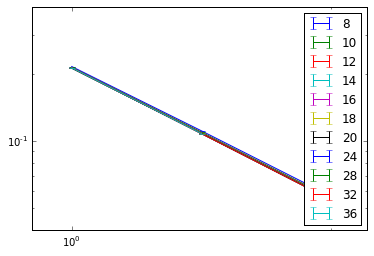

In [77]:
for L, df in chi_Tc.query('knorm > 0').groupby(level='L'):
    df.reset_index(inplace=True)
    df = df[df.LogSweeps == df.LogSweeps.max()]
    errorbar(df.knorm, df['mean'].values/L**2, df['sem'].values/L**2, label='{}'.format(L))
    
    df.to_csv('../data/chi-modes-p-Tc-L{:02d}.csv'.format(L), index=False)

xscale('log')
yscale('log')
xlim(0.9, 2.2)
ylim(0.04, 0.4)
legend()